In [1]:
import pandas as pd
import numpy as np
import psycopg2
import time
import requests
from io import StringIO

# Machine learning imports
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import AdaBoostRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import fbeta_score, make_scorer
from sklearn.metrics import confusion_matrix, accuracy_score, roc_curve, f1_score, mean_squared_error, r2_score

from sklearn import linear_model
from sklearn.linear_model import Lasso
from sklearn.linear_model import LinearRegression

import matplotlib.pyplot as plt
import chart_studio.plotly as py
import plotly.graph_objs as go
from astropy.table import Table, Column
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import scale 
from yellowbrick.regressor import PredictionError

from sklearn import svm, datasets
from sklearn.ensemble import ExtraTreesClassifier

import seaborn as sns
import pytack
import pandas_gbq

bqClient = pytack.BigQueryClient('tt-dp-prod')

/usr/local/lib/python3.6/site-packages/google/auth/_default.py:66: UserWarning:

Your application has authenticated using end user credentials from Google Cloud SDK. We recommend that most server applications use service accounts instead. If your application continues to use end user credentials from Cloud SDK, you might receive a "quota exceeded" or "API not enabled" error. For more information about service accounts, see https://cloud.google.com/docs/authentication/



In [2]:
import time
start = time.time()

Querying data and creating train/test datasets

In [3]:
users_7d = """
#standardsql

WITH cat_dma_date_data AS (
  SELECT *
  FROM UNNEST(GENERATE_DATE_ARRAY('2018-10-01', current_date)) as date
  CROSS JOIN (SELECT DISTINCT category FROM a.supply_health)
  CROSS JOIN (SELECT DISTINCT dma AS zip_dma FROM a.supply_health)
),

contacts_dma AS (
  SELECT cdd.*
    , SUM(contact_count) OVER (PARTITION BY cdd.category, cdd.zip_dma ORDER BY cdd.date DESC ROWS BETWEEN CURRENT ROW AND 27 FOLLOWING) AS market_contact_sum_28d
  FROM cat_dma_date_data AS cdd
  LEFT JOIN (
    SELECT DATE(first_customer_contact_time) AS contact_date
      , category
      , zip_dma
      , COUNT(DISTINCT contact_pk) AS contact_count
    FROM a.contacts AS c
    LEFT JOIN mode.zip_codes AS zc
      ON c.zip_code = zc.zip_code_id
    WHERE DATE(first_customer_contact_time) >= "2018-10-01"
    GROUP BY 1, 2, 3
  ) AS c
  ON cdd.date = c.contact_date  
    AND cdd.zip_dma = c.zip_dma
    AND cdd.category = c.category
),

rev_per_service_prior AS (
  SELECT date
    , category
    , dma
    --, IFNULL(num_services_30d_prior, 0) AS market_num_services_30d_prior
    , IFNULL(num_services_total, 0) AS market_num_services_total
    --, IFNULL(total_revenue_30d_prior, 0) AS market_total_revenue_30d_prior
    , ROUND(IFNULL(SAFE_DIVIDE(total_revenue_30d_prior, num_services_30d_prior), 0), 0) AS market_rev_per_service_30d_prior
  FROM (
    SELECT cdd.date
      , cdd.category
      , cdd.zip_dma AS dma
      , COUNT(DISTINCT CASE WHEN DATE_SUB(date, INTERVAL 30 DAY) > DATE(create_time) THEN s.service_pk ELSE NULL END) AS num_services_30d_prior
      , COUNT(DISTINCT CASE WHEN DATE(create_time) < date THEN s.service_pk ELSE NULL END) AS num_services_total
      , SUM(CASE WHEN 
              DATE_SUB(date, INTERVAL 30 DAY) > DATE(create_time) AND 
              DATE(sent_time) BETWEEN DATE_SUB(date, INTERVAL 30 DAY) AND date
            THEN q.revenue ELSE NULL END) AS total_revenue_30d_prior
    FROM cat_dma_date_data AS cdd
    LEFT JOIN a.services AS s
      ON cdd.category = s.category 
      AND cdd.zip_dma = s.dma
    LEFT JOIN (SELECT service_pk, sent_time, revenue FROM a.quotes) AS q
      ON s.service_pk = q.service_pk
    WHERE DATE(create_time) >= "2018-10-01"
    GROUP BY 1, 2, 3
  ) WHERE date >= "2018-11-28"
),

services AS (
  SELECT s.service_pk
    , s.pro_user_pk
    , s.create_time
    , s.category
    , s.dma
    , s.signup_channel
    , DATE_TRUNC(DATE(s.create_time), MONTH) AS service_create_month
    , EXTRACT(dayofweek FROM s.create_time) AS signup_day_of_week

    -- create category flags
    , CASE WHEN bc.category IS NOT NULL THEN 1 ELSE 0 END AS breadth_category
    , CASE WHEN dc.category IS NOT NULL THEN 1 ELSE 0 END AS depth_category
    , CASE WHEN (bc.category IS NULL AND dc.category IS NULL) THEN 1 ELSE 0 END AS scale_category

    -- create market status flags
    , CASE WHEN sh.market_status = "Promote Adoption" THEN 1 ELSE 0 END AS promote_adoption_market
    , CASE WHEN sh.market_status = "Need Quality Pros" THEN 1 ELSE 0 END AS need_quality_pros_market
    , CASE WHEN sh.market_status = "Healthy" THEN 1 ELSE 0 END AS healthy_pros_market

    , DATE_DIFF(current_date(), DATE(s.create_time), DAY) AS time_since_signup
    , MIN(DATE(s.create_time)) OVER (PARTITION BY pro_user_pk) AS earliest_service_signup_for_pro
    , CASE WHEN s.pass_gate_time BETWEEN s.create_time AND TIMESTAMP_ADD(s.create_time, INTERVAL 7 DAY) THEN 1 ELSE 0 END AS pass_gate_7d
    , sh.contactability_gap
    , sh.response_gap
    , sh.visitors

    -- get 28d sum of contacts in market before service sign-up
    , cd.market_contact_sum_28d
    , CASE WHEN (ea.min_service_delete_date IS NOT NULL AND DATE_DIFF(DATE(min_service_delete_date), DATE(s.create_time), DAY) < 7) THEN 1 ELSE 0 END AS deleted_within_7d
    , rs.market_num_services_total
    , rs.market_rev_per_service_30d_prior
  FROM a.services AS s
  LEFT JOIN reference.breadth_categories AS bc
    ON s.category_id = bc.category_id
  LEFT JOIN reference.depth_categories AS dc
    ON s.category_id = dc.category_id
  LEFT JOIN a.supply_health AS sh
    ON s.category = sh.category AND s.dma = sh.dma AND DATE(s.create_time) = sh.day
  LEFT JOIN contacts_dma AS cd
    ON s.category = cd.category AND s.dma = cd.zip_dma AND DATE(s.create_time) = cd.date
  LEFT JOIN rev_per_service_prior AS rs
    ON s.category = rs.category AND s.dma = rs.dma AND DATE(s.create_time) = rs.date
  LEFT JOIN (
    SELECT service_pk
      , MIN(event_timestamp) AS min_service_delete_date
    FROM events.analysis
    WHERE DATE(_PARTITIONTIME) > "2018-01-01" 
      AND event_type = "service/delete"
    GROUP BY 1
  ) AS ea
  ON s.service_pk = ea.service_pk
  WHERE DATE(s.create_time) >= "2018-11-28"
),

pro_app AS (
  SELECT service_pk
    , MIN(first_session_time) AS first_session_time
  FROM a.services as s
  LEFT JOIN b.user_platform_activity AS p
    ON s.pro_user_pk = p.user_pk
  WHERE app_type = "pro app"
  GROUP BY 1
),

contacts AS (
  SELECT s.service_pk
    , COUNTIF(c.first_customer_contact_time BETWEEN create_time AND TIMESTAMP_ADD(create_time, INTERVAL 7 DAY)) AS contacts_7d
    , COUNTIF(first_conversation_time BETWEEN create_time AND TIMESTAMP_ADD(create_time, INTERVAL 7 DAY)) AS conv_7d
  FROM a.services AS s
  LEFT JOIN a.contacts AS c
    ON s.service_pk = c.service_pk AND c.first_customer_contact_time BETWEEN s.create_time AND TIMESTAMP_ADD(s.create_time, INTERVAL 365 DAY) 
  WHERE 1 = 1
    AND DATE(s.create_time) >= "2018-11-28"
  GROUP BY 1
),

quotes AS (
  SELECT s.service_pk
    , COUNTIF(q.sent_time BETWEEN create_time AND TIMESTAMP_ADD(create_time, INTERVAL 7 DAY)) AS quotes_7d

    -- revenue calc for time buckets
    , SUM(CASE WHEN q.sent_time BETWEEN s.create_time AND TIMESTAMP_ADD(s.create_time, INTERVAL 7 DAY) THEN q.revenue ELSE 0 END) AS revenue_7d
    , SUM(CASE WHEN q.sent_time > TIMESTAMP_ADD(s.create_time, INTERVAL 7 DAY) AND q.sent_time <= TIMESTAMP_ADD(s.create_time, INTERVAL 30 DAY) THEN q.revenue ELSE 0 END) AS revenue_30d
    , SUM(CASE WHEN q.sent_time > TIMESTAMP_ADD(s.create_time, INTERVAL 7 DAY) AND q.sent_time <= TIMESTAMP_ADD(s.create_time, INTERVAL 60 DAY) THEN q.revenue ELSE 0 END) AS revenue_60d
    , SUM(CASE WHEN q.sent_time > TIMESTAMP_ADD(s.create_time, INTERVAL 7 DAY) AND q.sent_time <= TIMESTAMP_ADD(s.create_time, INTERVAL 90 DAY) THEN q.revenue ELSE 0 END) AS revenue_90d
    , SUM(CASE WHEN q.sent_time > TIMESTAMP_ADD(s.create_time, INTERVAL 7 DAY) AND q.sent_time <= TIMESTAMP_ADD(s.create_time, INTERVAL 180 DAY) THEN q.revenue ELSE 0 END) AS revenue_180d
    , SUM(CASE WHEN q.sent_time > TIMESTAMP_ADD(s.create_time, INTERVAL 7 DAY) AND q.sent_time <= TIMESTAMP_ADD(s.create_time, INTERVAL 365 DAY) THEN q.revenue ELSE 0 END) AS revenue_365d
  FROM a.services AS s
  LEFT JOIN a.quotes AS q 
    ON s.service_pk = q.service_pk AND q.sent_time BETWEEN s.create_time AND TIMESTAMP_ADD(s.create_time, INTERVAL 365 DAY) 
  WHERE 1 = 1
    AND DATE(s.create_time) > "2018-11-28"
  GROUP BY 1
),

promote_status AS (
  SELECT service_pk
    , MAX(promote_flag_7d) AS promote_flag_7d
  FROM (
    SELECT s.service_pk
      , CASE WHEN promote_timestamp BETWEEN s.create_time AND TIMESTAMP_ADD(s.create_time, INTERVAL 7 DAY) THEN 1 ELSE 0 END as promote_flag_7d
    FROM services AS s
    LEFT JOIN (
      SELECT service_pk
        , event_timestamp AS promote_timestamp
      FROM events.analysis
      WHERE 1 = 1
        AND DATE(_PARTITIONTIME) >= "2018-11-01"
        AND event_type = 'service request category/enable promote'
        AND DATE(event_timestamp) >= "2018-11-15"
      GROUP BY 1, 2) AS ea
    ON s.service_pk = ea.service_pk AND (promote_timestamp BETWEEN s.create_time AND TIMESTAMP_ADD(s.create_time, INTERVAL 7 DAY))
  ) GROUP BY 1
),

service_profile_features AS (
  SELECT s.service_pk
    , s.create_time

    -- number of videos
    , COUNT(DISTINCT (CASE WHEN vid_create_time BETWEEN s.create_time AND TIMESTAMP_ADD(s.create_time, INTERVAL 7 DAY) THEN vid_video_pk ELSE NULL END)) AS num_videos_7d

    -- number of pictures
    , COUNT(DISTINCT (CASE WHEN pic_upload_time BETWEEN s.create_time AND TIMESTAMP_ADD(s.create_time, INTERVAL 7 DAY) THEN pic_picture_pk ELSE NULL END)) AS num_pics_7d

    -- number of websites
    , COUNT(DISTINCT (CASE WHEN web_create_time BETWEEN s.create_time AND TIMESTAMP_ADD(s.create_time, INTERVAL 7 DAY) THEN web_website_pk ELSE NULL END)) AS num_websites_7d

    -- number of reviews
    , COUNT(DISTINCT (CASE WHEN review_create_time BETWEEN s.create_time AND TIMESTAMP_ADD(s.create_time, INTERVAL 7 DAY) THEN review_id ELSE NULL END)) AS num_reviews_7d
    , AVG(review_rating) AS avg_review_rating

  FROM a.services AS s

  -- videos
  LEFT JOIN (
    SELECT vid_sav_available_service_pk, TIMESTAMP_MILLIS(vid_create_time) AS vid_create_time, vid_video_pk
    FROM website.vid_videos
    ) AS v
  ON v.vid_sav_available_service_pk = s.service_pk
    AND v.vid_create_time BETWEEN s.create_time AND TIMESTAMP_ADD(s.create_time, INTERVAL 7 DAY)

  -- pictures
  LEFT JOIN (
      SELECT pic_sav_available_service_pk, pic_picture_pk
        , TIMESTAMP_MILLIS(pic_upload_time) AS pic_upload_time, TIMESTAMP_MILLIS(pic_delete_time) AS pic_delete_time
      FROM website.pic_pictures
    ) AS p
  ON p.pic_sav_available_service_pk = s.service_pk
    AND p.pic_upload_time BETWEEN s.create_time AND TIMESTAMP_ADD(s.create_time, INTERVAL 7 DAY)
    AND (p.pic_delete_time IS NULL OR p.pic_delete_time > TIMESTAMP_ADD(s.create_time, INTERVAL 7 DAY))

  -- websites
  LEFT JOIN (
    SELECT web_sav_available_service_pk, TIMESTAMP_MILLIS(web_create_time) AS web_create_time, web_website_pk
    FROM website.web_websites
    ) AS w
  ON w.web_sav_available_service_pk = s.service_pk
    AND web_create_time BETWEEN s.create_time AND TIMESTAMP_ADD(s.create_time, INTERVAL 7 DAY)

  -- reviews
  LEFT JOIN (
    SELECT rev.service_pk, review_id, rating AS review_rating
      , TIMESTAMP_MILLIS(create_time) AS review_create_time, TIMESTAMP_MILLIS(delete_time) AS delete_time
    FROM reviews.reviews rev
    ) AS r
  ON r.service_pk = s.service_pk
    AND review_create_time BETWEEN s.create_time AND TIMESTAMP_ADD(s.create_time, INTERVAL 7 DAY)
    AND (r.delete_time IS NULL OR r.delete_time > TIMESTAMP_ADD(s.create_time, INTERVAL 7 DAY))
  GROUP BY 1, 2
)

SELECT s.* EXCEPT(signup_channel)
    , LOG(revenue_30d+1) AS revenue_30d_log
    , LOG(revenue_7d+1) AS revenue_7d_log
    , IFNULL(avg_review_rating, 0) AS avg_review_rating
    , IFNULL(signup_channel, "Unknown") AS signup_channel
    , CASE WHEN (DATE(s.create_time) < earliest_service_signup_for_pro) THEN 1 ELSE 0 END AS other_services_prior
    , q.* EXCEPT(service_pk)
    , c.* EXCEPT(service_pk)
    , ps.* EXCEPT(service_pk)
    , spf.* EXCEPT(service_pk, create_time, avg_review_rating)
    , IF(num_videos_7d > 0, 1, 0) AS videos_7d_flag 
    , IF(num_reviews_7d > 0, 1, 0) AS reviews_7d_flag
    , IF(num_websites_7d > 0, 1, 0) AS websites_7d_flag
    , IF(num_pics_7d > 0, 1, 0) AS pics_7d_flag
    , CASE WHEN time_since_signup >= 60 THEN 1 ELSE 0 END AS service_gt_60d
    , CASE WHEN time_since_signup >= 30 THEN 1 ELSE 0 END AS service_gt_30d
    , CASE WHEN (p.first_session_time IS NOT NULL AND p.first_session_time <= TIMESTAMP_ADD(s.create_time, INTERVAL 7 DAY)) THEN 1 ELSE 0 END AS app_within_7d
FROM services AS s
LEFT JOIN contacts AS c
  ON s.service_pk = c.service_pk
LEFT JOIN quotes AS q
  ON s.service_pk = q.service_pk
LEFT JOIN service_profile_features AS spf
  ON s.service_pk = spf.service_pk
LEFT JOIN pro_app AS p
  ON s.service_pk = p.service_pk
LEFT JOIN promote_status AS ps
  ON s.service_pk = ps.service_pk
"""

In [4]:
# run query to get service-level data
all_users_7d = bqClient.query(users_7d)
print("Total number of service sign-ups after 11/28:", len(all_users_7d))

Total number of service sign-ups after 11/28: 233340


In [5]:
#subset to services that have been around for 30-60+ days
all_data_7d_30d = all_users_7d[all_users_7d['service_gt_30d'] == 1]
all_data_7d_30d_50 = all_data_7d_30d[all_data_7d_30d['visitors'] >= 270]
all_data_7d_30d_75 = all_data_7d_30d[all_data_7d_30d['visitors'] >= 70]
all_data_7d_30d_90 = all_data_7d_30d[all_data_7d_30d['visitors'] >= 18]

all_data_7d_60d = all_users_7d[all_users_7d['service_gt_60d'] == 1]

In [6]:
print("# services with at least 30 days since sign-up:", len(all_data_7d_30d))
print("# services with at least 60 days since sign-up:", len(all_data_7d_60d))

# services with at least 30 days since sign-up: 204680
# services with at least 60 days since sign-up: 177974


In [7]:
# function to split data into train/test data
def shuffle_split_data(features, labels):
    X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size = 0.3)
    return X_train, X_test, y_train, y_test

In [8]:
all_data_7d_30d_90.head()

,service_pk,pro_user_pk,create_time,category,dma,service_create_month,signup_day_of_week,breadth_category,depth_category,scale_category,...,num_pics_7d,num_websites_7d,num_reviews_7d,videos_7d_flag,reviews_7d_flag,websites_7d_flag,pics_7d_flag,service_gt_60d,service_gt_30d,app_within_7d
0,356751388743196675,356751388585148417,2019-04-22 01:36:29.136000+00:00,Handyman,WEST PALM BEACH-FT. PIERCE,2019-04-01,2,1,0,0,...,0,0,0,0,0,0,0,1,1,1
1,360035362686541828,360035362518654980,2019-05-30 01:49:23.237000+00:00,Pet Sitting,NEW YORK,2019-05-01,5,1,0,0,...,0,0,1,0,1,0,0,1,1,1
2,364074186617102336,364074186439122946,2019-07-15 19:43:06.950000+00:00,Concrete Installation,GREENSBORO-H.POINT-W.SALEM,2019-07-01,2,1,0,0,...,0,0,0,0,0,0,0,0,1,0
3,348791778133958666,348791745060593675,2019-01-19 22:36:18.763000+00:00,Electrical and Wiring Repair,SAN FRANCISCO-OAK-SAN JOSE,2019-01-01,7,0,0,1,...,0,0,0,0,0,0,0,1,1,1
5,353020245882159126,353020208502276117,2019-03-09 21:10:46.236000+00:00,House Cleaning,RALEIGH-DURHAM (FAYETVLLE),2019-03-01,7,0,1,0,...,0,0,0,0,0,0,0,1,1,0


In [9]:
# remove rows with unknown values
# maybe not drop it? examine null data, maybe fill the values in, medians o
data_7d_30d = all_data_7d_30d.dropna()
data_7d_60d = all_data_7d_60d.dropna()

data_7d_30d_50 = all_data_7d_30d_50.dropna()
data_7d_30d_75 = all_data_7d_30d_75.dropna()
data_7d_30d_90 = all_data_7d_30d_90.dropna()

# create dummy variables
# might not be in the dummy variable? say we come up with a new category
model_data_7d_30d = pd.get_dummies(data_7d_30d, columns = ['category', 'dma', 'signup_channel', 'signup_day_of_week'])
model_data_7d_30d_50 = pd.get_dummies(data_7d_30d_50, columns = ['category', 'dma', 'signup_channel', 'signup_day_of_week'])
model_data_7d_30d_75 = pd.get_dummies(data_7d_30d_75, columns = ['category', 'dma', 'signup_channel', 'signup_day_of_week'])
model_data_7d_30d_90 = pd.get_dummies(data_7d_30d_90, columns = ['category', 'dma', 'signup_channel', 'signup_day_of_week'])

model_data_7d_60d = pd.get_dummies(data_7d_60d, columns = ['category', 'dma', 'signup_channel', 'signup_day_of_week'])

In [35]:
# TODO check is null in input data. Maybe avg or medians
all_data_7d_30d.isnull().sum()

service_pk                              0
pro_user_pk                             0
create_time                             0
category                             1165
dma                                   873
service_create_month                    0
signup_day_of_week                      0
breadth_category                        0
depth_category                          0
scale_category                          0
promote_adoption_market                 0
need_quality_pros_market                0
healthy_pros_market                     0
time_since_signup                       0
earliest_service_signup_for_pro         0
pass_gate_7d                            0
contactability_gap                   4206
response_gap                         4206
visitors                             4206
market_contact_sum_28d              13470
deleted_within_7d                       0
market_num_services_total            2319
market_rev_per_service_30d_prior     2319
revenue_30d_log                   

In [34]:
# sanity check column headers
list(model_data_7d_30d_50.columns.values)

['service_pk',
 'pro_user_pk',
 'create_time',
 'service_create_month',
 'breadth_category',
 'depth_category',
 'scale_category',
 'promote_adoption_market',
 'need_quality_pros_market',
 'healthy_pros_market',
 'time_since_signup',
 'earliest_service_signup_for_pro',
 'pass_gate_7d',
 'contactability_gap',
 'response_gap',
 'visitors',
 'market_contact_sum_28d',
 'deleted_within_7d',
 'market_num_services_total',
 'market_rev_per_service_30d_prior',
 'revenue_30d_log',
 'revenue_7d_log',
 'avg_review_rating',
 'other_services_prior',
 'quotes_7d',
 'revenue_7d',
 'revenue_30d',
 'revenue_60d',
 'revenue_90d',
 'revenue_180d',
 'revenue_365d',
 'contacts_7d',
 'conv_7d',
 'promote_flag_7d',
 'num_videos_7d',
 'num_pics_7d',
 'num_websites_7d',
 'num_reviews_7d',
 'videos_7d_flag',
 'reviews_7d_flag',
 'websites_7d_flag',
 'pics_7d_flag',
 'service_gt_60d',
 'service_gt_30d',
 'app_within_7d',
 'category_AV Equipment Rental for Events',
 'category_Accounting',
 'category_Administrative

In [10]:
drop_labels = ['service_pk', 'create_time', 'pro_user_pk', 'earliest_service_signup_for_pro'
               , 'service_gt_30d', 'service_gt_60d', 'service_create_month', 'time_since_signup'
               , 'revenue_30d', 'revenue_7d_log', 'revenue_30d_log', 'revenue_60d','revenue_90d'
               , 'revenue_180d', 'revenue_365d']

features_7d_60d = model_data_7d_60d.drop(labels = drop_labels, axis = 1)
features_7d_30d = model_data_7d_30d.drop(labels = drop_labels, axis = 1)
features_7d_30d_50 = model_data_7d_30d_50.drop(labels = drop_labels, axis = 1)
features_7d_30d_75 = model_data_7d_30d_75.drop(labels = drop_labels, axis = 1)
features_7d_30d_90 = model_data_7d_30d_90.drop(labels = drop_labels, axis = 1)

labels_7d_60d = model_data_7d_60d.revenue_60d.astype(int)
labels_7d_30d = model_data_7d_30d.revenue_30d.astype(int)
labels_7d_30d_50 = model_data_7d_30d_50.revenue_30d.astype(int)
labels_7d_30d_75 = model_data_7d_30d_75.revenue_30d.astype(int)
labels_7d_30d_90 = model_data_7d_30d_90.revenue_30d.astype(int)

In [11]:
x_train_30d, x_test_30d, y_train_30d, y_test_30d = shuffle_split_data(features_7d_30d, labels_7d_30d)
x_train_30d_50, x_test_30d_50, y_train_30d_50, y_test_30d_50 = shuffle_split_data(features_7d_30d_50, labels_7d_30d_50)
x_train_30d_75, x_test_30d_75, y_train_30d_75, y_test_30d_75 = shuffle_split_data(features_7d_30d_75, labels_7d_30d_75)
x_train_30d_90, x_test_30d_90, y_train_30d_90, y_test_30d_90 = shuffle_split_data(features_7d_30d_90, labels_7d_30d_90)

x_train_60d, x_test_60d, y_train_60d, y_test_60d = shuffle_split_data(features_7d_60d, labels_7d_60d)


In [ ]:
# TODO - try splitting time based. Week intervals (ie always start on a monday)

Random forest model to predict 30 day revenue, capturing 50% of services (visitors > 270)

In [12]:
# 30d rev prediction model: capture 50% of services (visitors > 270)
rf_30d_50 = RandomForestRegressor(n_estimators = 100, max_depth = 10, random_state = 42)

# Train the model on training data
rf_30d_50.fit(x_train_30d_50, y_train_30d_50)

rf_y_pred_30d_50 = rf_30d_50.predict(x_test_30d_50)

rf_r2_30d_50 = r2_score(y_test_30d_50, rf_y_pred_30d_50).round(4)

In [ ]:
# TODO exp grid search

In [13]:
end = time.time()
print("Time between start of querying/manipulating data and running model is:",end - start)

Time between start of querying/manipulating data and running model is: 343.9883053302765


Random forest model to predict 30 day revenue, capturing 75% of services (visitors > 70)

In [14]:
# 30d rev prediction model: capture 75% of services (visitors > 70)
rf_30d_75 = RandomForestRegressor(n_estimators = 100, max_depth = 10, random_state = 42)

# Train the model on training data
rf_30d_75.fit(x_train_30d_75, y_train_30d_75)

rf_y_pred_30d_75 = rf_30d_75.predict(x_test_30d_75)

rf_r2_30d_75 = r2_score(y_test_30d_75, rf_y_pred_30d_75).round(4)

Random forest model to predict 30 day revenue, capturing 90% of services (visitors > 18)

In [15]:
# 30d rev prediction model: capture 90% of services (visitors > 18)
rf_30d_90 = RandomForestRegressor(n_estimators = 100, max_depth = 10, random_state = 42)
 
# Train the model on training data
rf_30d_90.fit(x_train_30d_90, y_train_30d_90)

rf_y_pred_30d_90 = rf_30d_90.predict(x_test_30d_90)

rf_r2_30d_90 = r2_score(y_test_30d_90, rf_y_pred_30d_90).round(4)

Random forest model to predict 30 day revenue

In [16]:
# 30d rev prediction model
rf_30d = RandomForestRegressor(n_estimators = 100, max_depth = 10, random_state = 42)

# Train the model on training data
rf_30d.fit(x_train_30d, y_train_30d)

rf_y_pred_30d = rf_30d.predict(x_test_30d)

rf_r2_30d = r2_score(y_test_30d, rf_y_pred_30d).round(4)

Random forest model to predict 60 day revenue

In [17]:
# 60d rev prediction model
rf_60d = RandomForestRegressor(n_estimators = 100, max_depth = 10, random_state = 42)

# Train the model on training data
rf_60d.fit(x_train_60d, y_train_60d)

rf_y_pred_60d = rf_60d.predict(x_test_60d)

rf_r2_60d = r2_score(y_test_60d, rf_y_pred_60d).round(4)
print("R^2 for 60d revenue model:", rf_r2_60d)

R^2 for 60d revenue model: 0.2525


Plot actual 30d predicted and actual revenue numbers

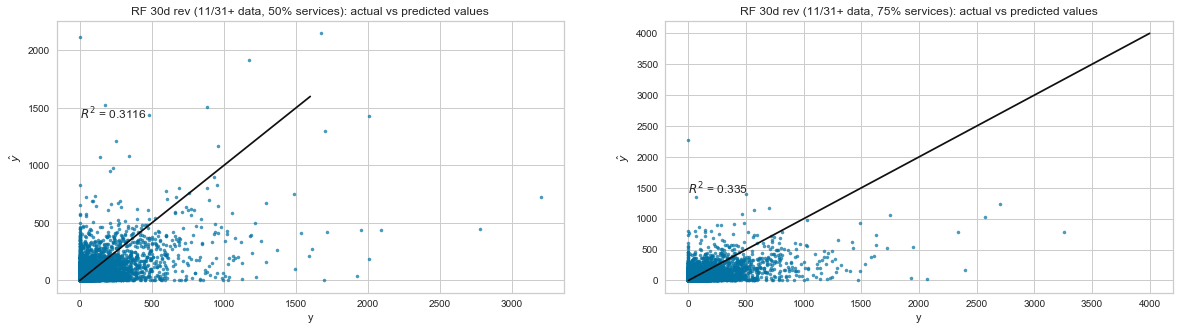

In [18]:
fig, ax = plt.subplots(figsize = (20, 5))
x = np.linspace(0, 1600, 101) 

plt.subplot(1, 2, 1) # num rows, num columns, plot you're on
plt.grid(True)
plt.xlabel("y")
plt.ylabel("$\hat{y}$")
plt.title('RF 30d rev (11/31+ data, 50% services): actual vs predicted values')
plt.scatter(y_test_30d_50, rf_y_pred_30d_50, alpha = 0.7, s = 10)
plt.text(0, 1400, "$R^2$ = {}".format(rf_r2_30d_50), fontsize = 12)

plt.plot(x,x,'k-') # x=y line

x2 = np.linspace(0, 4000, 101) 
plt.subplot(1, 2, 2) # num rows, num columns, plot you're on
plt.grid(True)
plt.xlabel("y")
plt.ylabel("$\hat{y}$")
plt.title('RF 30d rev (11/31+ data, 75% services): actual vs predicted values')
plt.scatter(y_test_30d_75, rf_y_pred_30d_75, alpha = 0.7, s = 10)
plt.text(0, 1400, "$R^2$ = {}".format(rf_r2_30d_75), fontsize = 12)

plt.plot(x2, x2,'k-') # x=y line

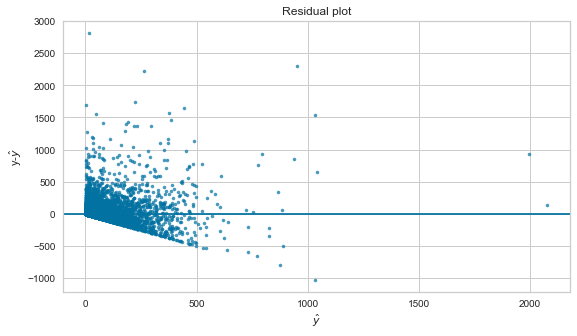

In [19]:
y_pred_actual_diff = y_test_30d - rf_y_pred_30d

fig, ax = plt.subplots(figsize = (20, 5))
x = np.linspace(0, 1600, 101) 

plt.subplot(1, 2, 1) # num rows, num columns, plot you're on
plt.grid(True)
plt.xlabel("$\hat{y}$")
plt.ylabel("y-$\hat{y}$")
plt.title('Residual plot')
plt.scatter(rf_y_pred_30d, y_pred_actual_diff, alpha = 0.7, s = 10)

plt.axhline(y=1)

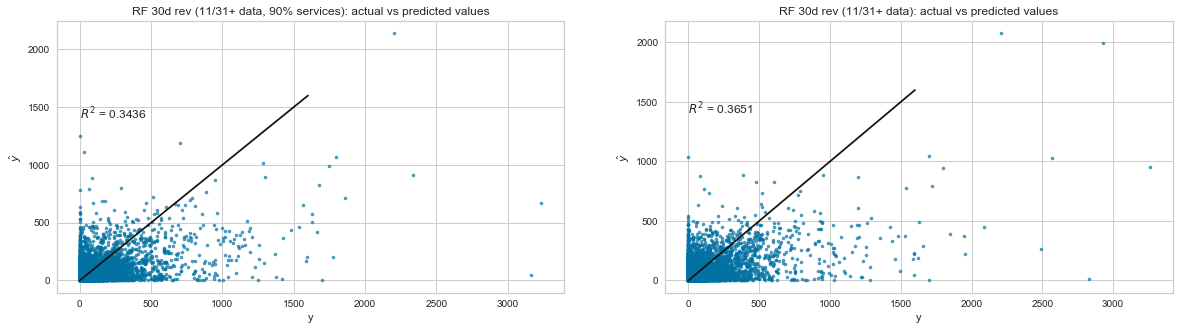

In [20]:
fig, ax = plt.subplots(figsize = (20, 5))
x = np.linspace(0, 1600, 101) 

plt.subplot(1, 2, 1) # num rows, num columns, plot you're on
plt.grid(True)
plt.xlabel("y")
plt.ylabel("$\hat{y}$")
plt.title('RF 30d rev (11/31+ data, 90% services): actual vs predicted values')
plt.scatter(y_test_30d_90, rf_y_pred_30d_90, alpha = 0.7, s = 10)
plt.text(0, 1400, "$R^2$ = {}".format(rf_r2_30d_90), fontsize = 12)

plt.plot(x,x,'k-') # x=y line

plt.subplot(1, 2, 2) # num rows, num columns, plot you're on
plt.grid(True)
plt.xlabel("y")
plt.ylabel("$\hat{y}$")
plt.title('RF 30d rev (11/31+ data): actual vs predicted values')
plt.scatter(y_test_30d, rf_y_pred_30d, alpha = 0.7, s = 10)
plt.text(0, 1400, "$R^2$ = {}".format(rf_r2_30d), fontsize = 12)

plt.plot(x,x,'k-') # x=y line

# calibration plot 

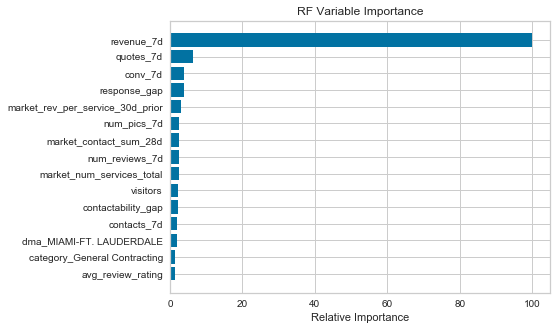

In [21]:
# Feature importance plot

feature_importance_30d = rf_30d.feature_importances_
column_names_30d = np.asarray(list(features_7d_30d.columns.values))

# make importances relative to max importance
feature_importance_30d = 100.0 * (feature_importance_30d / feature_importance_30d.max())

sorted_idx_30d = np.argsort(feature_importance_30d)
sorted_idx_30d = sorted_idx_30d[-15:]
pos_30d = np.arange(sorted_idx_30d.shape[0]) + .5

fig, ax = plt.subplots(figsize = (15, 5))
plt.subplot(1, 2, 1) # num rows, num columns, plot #
plt.barh(pos_30d, feature_importance_30d[sorted_idx_30d], align = 'center')
plt.yticks(pos_30d, column_names_30d[sorted_idx_30d])
plt.xlabel('Relative Importance')
plt.title('RF Variable Importance')
plt.gca().xaxis.grid(True)

In [22]:
column_names_30d[sorted_idx_30d]

array(['avg_review_rating', 'category_General Contracting',
       'dma_MIAMI-FT. LAUDERDALE', 'contacts_7d', 'contactability_gap',
       'visitors', 'market_num_services_total', 'num_reviews_7d',
       'market_contact_sum_28d', 'num_pics_7d',
       'market_rev_per_service_30d_prior', 'response_gap', 'conv_7d',
       'quotes_7d', 'revenue_7d'], dtype='<U63')

Random forest model to predict 30d revenue using top predictors from model above

In [23]:
x_train_30d_subset_predictors = x_train_30d[['dma_DENVER', 'category_General Contracting', 'avg_review_rating',
       'contacts_7d', 'num_reviews_7d', 'visitors', 'contactability_gap',
       'conv_7d', 'market_contact_sum_28d', 'response_gap', 'num_pics_7d',
       'market_rev_per_service_30d_prior', 'market_num_services_total',
       'quotes_7d', 'revenue_7d']]

x_test_30d_subset_predictors = x_test_30d[['dma_DENVER', 'category_General Contracting', 'avg_review_rating',
       'contacts_7d', 'num_reviews_7d', 'visitors', 'contactability_gap',
       'conv_7d', 'market_contact_sum_28d', 'response_gap', 'num_pics_7d',
       'market_rev_per_service_30d_prior', 'market_num_services_total',
       'quotes_7d', 'revenue_7d']]

# # 30d rev prediction model 
rf_30d_15_preds = RandomForestRegressor(n_estimators = 100, random_state = 42)

# # Train the model on training data
rf_30d_15_preds.fit(x_train_30d_subset_predictors, y_train_30d)

rf_y_pred_30d_15_preds = rf_30d_15_preds.predict(x_test_30d_subset_predictors)

rf_r2_30d_15_preds = r2_score(y_test_30d, rf_y_pred_30d_15_preds).round(4)

In [39]:
# MSE
mean_squared_error(y_test_30d, rf_y_pred_30d_15_preds)
# OOB
rf_30d_15_preds.oob_score_

AttributeError: 'RandomForestRegressor' object has no attribute 'oob_score_'

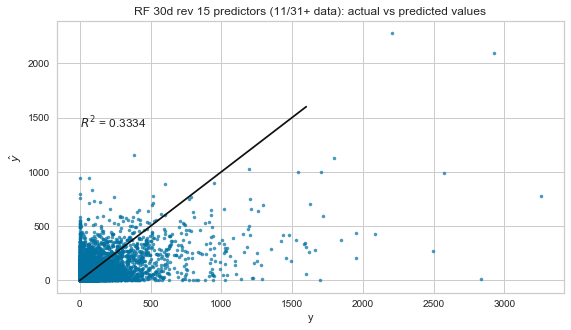

In [24]:
fig, ax = plt.subplots(figsize = (20, 5))
x = np.linspace(0, 1600, 101) 

plt.subplot(1, 2, 1) # num rows, num columns, plot you're on
plt.grid(True)
plt.xlabel("y")
plt.ylabel("$\hat{y}$")
plt.title('RF 30d rev 15 predictors (11/31+ data): actual vs predicted values')
plt.scatter(y_test_30d, rf_y_pred_30d_15_preds, alpha = 0.7, s = 10)
plt.text(0, 1400, "$R^2$ = {}".format(rf_r2_30d_15_preds), fontsize = 12)

plt.plot(x,x,'k-') # x=y line

In [ ]:
# TODO look at adjusted R^2, MSE, MAE

In [25]:
# run random forest model to predict log(30d) revenue

rf_log_30d = RandomForestRegressor(n_estimators = 100, random_state = 42, max_depth = 10)

# Train the model on training data
rf_log_30d.fit(x_train_30d, np.log(y_train_30d+1))

rf_log_y_pred_30d = rf_log_30d.predict(x_test_30d)
rf_log_r2_30d = r2_score(y_test_30d, np.exp(rf_log_y_pred_30d)).round(4)

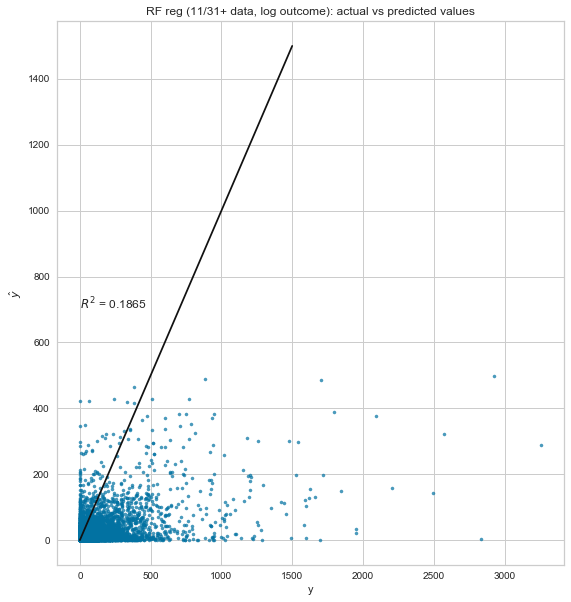

In [26]:
x1 = np.linspace(0, 1500, 101) 

fig, ax = plt.subplots(figsize = (20, 10))

plt.subplot(1, 2, 2) # num rows, num columns, plot you're on
plt.grid(True)
plt.xlabel("y")
plt.ylabel("$\hat{y}$")
plt.title('RF reg (11/31+ data, log outcome): actual vs predicted values')
plt.scatter(y_test_30d, np.exp(rf_log_y_pred_30d)-1, alpha = 0.7, s = 10)
plt.text(0, 700, "$R^2$ = {}".format(rf_log_r2_30d), fontsize = 12)

plt.plot(x1, x1,'k-') # x=y line

In [27]:
test_y_pred_30d = pd.DataFrame(rf_y_pred_30d, columns = ["y_pred_30d"], index = x_test_30d.index)

test_data_30d = pd.concat([x_test_30d, y_test_30d, test_y_pred_30d], axis = 1)

# i know this is not ideal but not able to quickly find a new command to handle this
test_data_30d.columns = test_data_30d.columns.str.replace(' ', '_')
test_data_30d.columns = test_data_30d.columns.str.replace(',', '')
test_data_30d.columns = test_data_30d.columns.str.replace('(', '')
test_data_30d.columns = test_data_30d.columns.str.replace(')', '')
test_data_30d.columns = test_data_30d.columns.str.replace('-', '')
test_data_30d.columns = test_data_30d.columns.str.replace('&', '')
test_data_30d.columns = test_data_30d.columns.str.replace('.', '')

In [31]:
test_data_30d_with_create_month = test_data_30d.join(model_data_7d_30d[['service_pk','service_create_month','create_time', 'pro_user_pk', 'earliest_service_signup_for_pro'
               , 'service_gt_30d', 'service_gt_60d'
               , 'revenue_7d_log', 'revenue_30d_log', 'revenue_60d','revenue_90d'
               , 'revenue_180d', 'revenue_365d']], how = "left")

test_data_30d_with_create_month = test_data_30d_with_create_month.join(data_7d_30d[['category','dma']], how = "left")

test_data_30d_with_create_month.to_gbq("jlin.cd_test_data_30d_ltv_20190815", project_id = 'tt-dp-dev', if_exists = 'fail')
